In [5]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
from sasaki_metric import SasakiMetric
from geomstats.geometry.hypersphere import Hypersphere
from geomstats.learning.frechet_mean import FrechetMean
from geomstats.learning.pca import TangentPCA
from geomstats.learning.geodesic_regression import GeodesicRegression
import geomstats.backend as gs
from util import visSphere, visKen, visKenPCA, load_data, initial_mean

Nt = 25
t = gs.linspace(0, 1, Nt)

## Sasaki Metric and Applications in Geodesic Analysis

Authors: Dr. Esfandiar Nava-Yazdani and Dr. Christoph von Tycowicz

1.  Introduction and motivation
    Riemannian metric on the tangent bundle
    A prominent natural metric on the tangent bundle TM of a Riemannian manifold M is the Sasaki metric.
    Its characterization: Canonical projection of TM becomes a Riemannian submersion, parallel vector fields
    along curves are orthogonal to their fibres, and restriction to any tangent space is Euclidean.

        Longitudinal analysis and mean geodesic

2.  Related Works and Implementations
    -   [A Hierarchical Geodesic Model for Longitudinal Analysis on Manifolds](https://doi.org/10.1007/s10851-022-01079-x)
    -   [Sasaki Metrics for Analysis of Longitudinal Data on Manifolds](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4270017)

3.  Implementation of Sasaki metric

4.  Applications

Application: Shortest paths and mean of geodesics on the 2-Sphere

In [2]:
S2 = Hypersphere(dim=2)
S2_metric = S2.metric
# bypass geomstats bug: shape property of HypersphereMetric not initialized consistently
if S2.default_coords_type == 'extrinsic':
    S2_metric.shape = (S2.dim+1,)
sas = SasakiMetric(S2.metric)

Compute the shortest path

INFO: reached tolerance 1e-06
INFO: iterations: 0
INFO: |grad|: 7.944077613204419e-16


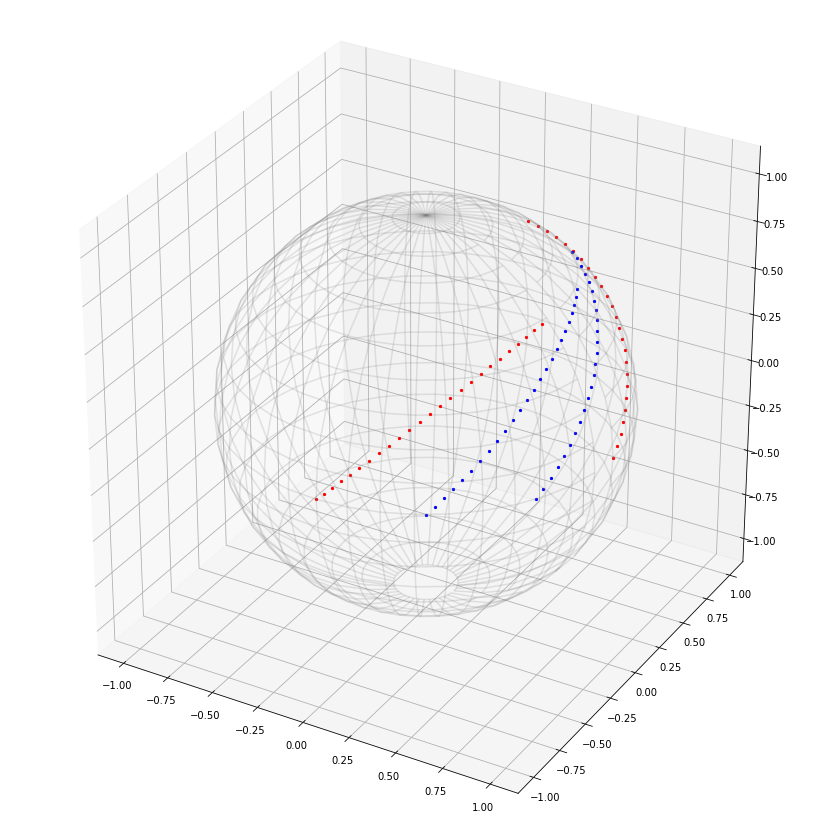

In [3]:
p0, u0 = gs.array([0., -1, 0]), gs.array([1., 0, 1])
pu0 = gs.array([p0, u0])
pL, uL = gs.array([1., 0, 0]), gs.array([0., 1, 1])
puL = gs.array([pL, uL])
# print('Computing shortest path of geodesics')
z = sas.geodesic_discrete(pu0, puL)
geo_list, color_list = [], []
geods0L, geods = [], []
geods0L.append(S2_metric.geodesic(p0, initial_tangent_vec=u0)(t))
geods0L.append(S2_metric.geodesic(pL, initial_tangent_vec=uL)(t))
geo_list = [geods0L]
for j in range(1, len(z) - 1):
    p1, u1 = z[j][0], z[j][1]
    geods.append(S2_metric.geodesic(p1, initial_tangent_vec=u1)(t))
geo_list += [geods]
visSphere(geo_list, ['r']+['b'], 15)

Compute the mean

INFO: reached tolerance 1e-06
INFO: iterations: 0
INFO: |grad|: 1.2266837977547646e-15


Computing mean of geodesics


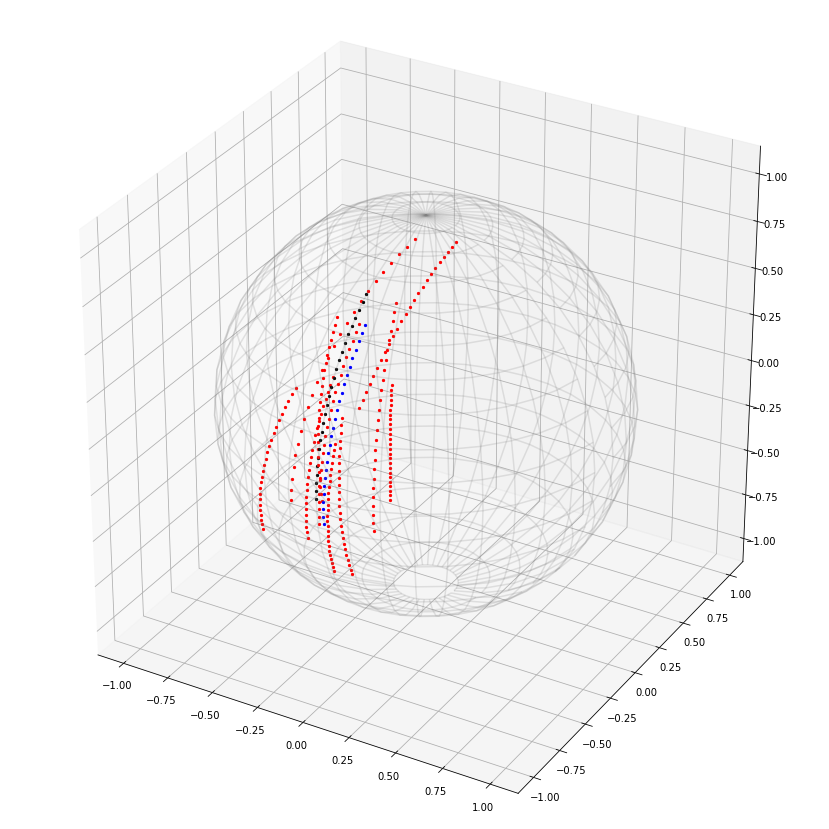

In [6]:
m = gs.array([[0, -1.0, 0], [0, 0, 1.0]])
n_samples, sigma = 10, gs.pi/12
x = S2.random_riemannian_normal(m[0], n_samples=n_samples)
y = S2.random_riemannian_normal(m[0], n_samples=n_samples)
x = [S2_metric.exp(sigma*S2_metric.log(x[i], m[0]), m[0]) for i in range(n_samples)]
u = [m[1] + sigma*S2_metric.log(y[i], m[0]) for i in range(n_samples)]
samples = [gs.array([x[i], u[i]]) for i in range(n_samples)]

print('Computing mean of geodesics')
initial = initial_mean(samples, S2_metric)
mean_gs = FrechetMean(sas, init_point=initial)
mean_gs.fit(samples)
mean = mean_gs.estimate_
# mean = sas.mean(samples)
data, meanvalue, geom = [], [], []
meanvalue.append(S2_metric.geodesic(m[0], initial_tangent_vec=m[1])(t))
geom.append(S2_metric.geodesic(mean[0], initial_tangent_vec=mean[1])(t))
for sample in samples:
    data.append(S2_metric.geodesic(sample[0], initial_tangent_vec=sample[1])(t))
visSphere([data] + [meanvalue] + [geom], ['r'] + ['k'] + ['b'], 15)

Application: Geodesic Analysis and Clustering via Regression in Kendall's Shape Space

we use Vilmann’s rat calvaria (skulls excluding the lower jaw) that have been
obtained from X-ray images. It consists of 8 landmarks in 2 dimensions for 18
individuals observed at ages of 7, 14, 21, 30, 40, 60, 90, 150 days.
For the shape analysis, we use the 2D-Kendall's shape space.

![rat](ratyz.png)

Total number of rat skulls: 144


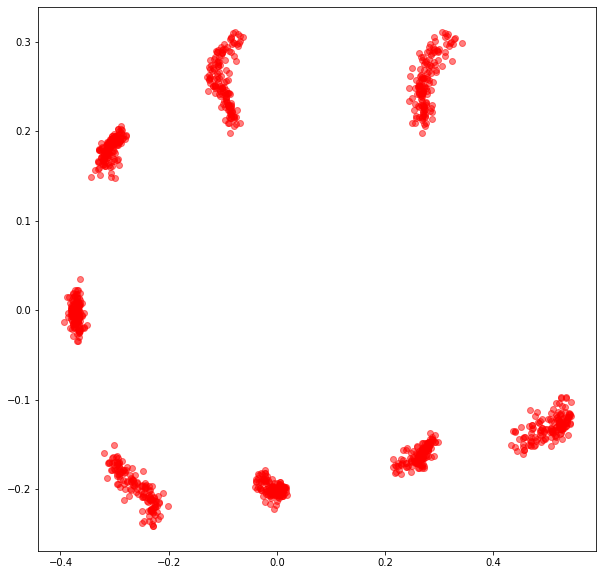

In [6]:
samples = load_data()
n_samples = len(samples)
print(f"Total number of rat skulls: {n_samples}")
n_subjects, n_trj, k_landmarks, dim = 18, 8, 8, 2
Ken = PreShapeSpace(k_landmarks, dim)
KenMetric = KendallShapeMetric(k_landmarks, dim)
KenMetric.shape = Ken.shape # fix: shape not set consistently
sas = SasakiMetric(KenMetric)
samples = [Ken.projection(samples[i]) for i in range(n_samples)]
visKen([samples], ['r'])
samples = gs.array(samples).reshape(n_subjects, n_trj, k_landmarks, dim)

Employ regression to represent the trajectories by points in the tangent bundle, hence geodesics.

In [ ]:
# Regression
# ln 266 in pre_shape.py -> add full_matrices=False to svd call (otherwise no autodiff)
reg = GeodesicRegression(Ken, KenMetric, method="riemannian", initialization="warm_start")
# TODO
geos, geodesics = [], []
x = gs.linspace(0, 1, n_trj)
for trj in samples:
    #Change backend to tensorflow, autodiff or pytorch and samples to array
    reg.intercept_ = trj[0]
    reg.coef_ = KenMetric.log(trj[-1], trj[0])
    reg.fit(x, trj, compute_training_score=True)
    print('R^2:', reg.training_score_)
    p, u = reg.intercept_, reg.coef_
    geos.append(gs.array([p, u]))
    geodesic = KenMetric.geodesic(initial_point=p, initial_tangent_vec=u)(t)
    geodesics.append(geodesic(t))

In [ ]:
# Tangent PCA
mean_gs = FrechetMean(sas)
mean_gs.fit(geos)
mean = mean_gs.estimate_
mean_geo = KenMetric.geodesic(initial_point=mean[0], initial_tangent_vec=mean[1])(t)
visKen([geodesics]+[mean_geo], ['b']+['k'])
# TPCA
tpca = TangentPCA(metric=KenMetric, n_components=2)
tpca = tpca.fit(geos, base_point=mean)
tangent_projected_data = tpca.transform(geos)
geo_0 = KenMetric.geodesic(initial_point=mean, initial_tangent_vec=tpca.components_[0])(t)
geo_1 = KenMetric.geodesic(initial_point=mean, initial_tangent_vec=tpca.components_[1])(t)
visKenPCA([geo_0]+[geo_1], tpca.explained_variance_ratio_, samples, mean)
# Learning